In [7]:
from aiida.orm import Dict, Str,List,Code,FolderData,RemoteData,Float,Int,ArrayData,load_code
from aiida.engine import run,submit,run_get_node,ExitCode,WorkChain,workfunction,calcfunction,ToContext
from aiida.plugins import DataFactory
import os
import pickle
import numpy as np

from cryspy.job import ctrl_job


StructureCollectionData = DataFactory("cryspy.structurecollection")
PandasFrameData = DataFactory('dataframe.frame')
RinData = DataFactory('cryspy.rin_data')
EAData = DataFactory('cryspy.ea_data')
LammpsPotentialData = DataFactory("lammps.potential")
LammpsTrajectoryData = DataFactory("lammps.trajectory")
StructureData = DataFactory('core.structure')

In [8]:
from aiida import load_profile
load_profile()

Profile<uuid='96abe6da047b431294d9057e5dbc634c' name='quicksetup'>

In [6]:

class initialize_workchain(WorkChain):

    @classmethod
    def define(cls,spec):
        super().define(spec)
        spec.input("cryspy_in_filename",valid_type=Str)
        #lock_cryspyをinputで入れる？

        spec.output("initial_structures",valid_type=StructureCollectionData)
        spec.output("opt_structures",valid_type=StructureCollectionData)
        spec.output("rslt_data",valid_type=PandasFrameData)
        spec.output("cryspy_in",valid_type=RinData)
        spec.output("id_queueing",valid_type=List)
        spec.output('detail_data', valid_type=(Dict,EAData))

        spec.outline(
            cls.call_crsypy_initialize
        )

    def call_crsypy_initialize(self):
        from cryspy.interactive import action
        init_struc_data, opt_struc_data, rin, rslt_data, id_queueing, detail_data = action.initialize()


        init_struc_node = StructureCollectionData(structures=init_struc_data)
        init_struc_node.store()
        self.out('initial_structures', init_struc_node)

        opt_struc_node = StructureCollectionData(structures=opt_struc_data)
        opt_struc_node.store()
        self.out('opt_structures', opt_struc_node)

        rslt_node = PandasFrameData(rslt_data)
        rslt_node.store()
        self.out('rslt_data', rslt_node)

        cryspy_in = RinData(rin)
        cryspy_in.store()
        self.out("cryspy_in", cryspy_in)

        id_queueing_node = List(list=id_queueing)
        id_queueing_node.store()
        self.out("id_queueing", id_queueing_node)

        algo = rin.algo
        
        if algo == "RS":
            RS_node = Dict(dict=detail_data)
            RS_node.store()
            self.out('detail_data', RS_node)

        elif algo == "EA":
            ea_node = EAData(detail_data)
            ea_node.store()
            self.out('detail_data', ea_node)

In [9]:
result,node = run.get_node(initialize_workchain, cryspy_in_filename="cryspy_in")

[2025-07-24 12:30:38,837][cryspy_init][INFO] 


Start CrySPY 1.4.0b10


[2025-07-24 12:30:38,838][cryspy_init][INFO] # ---------- Library version info
[2025-07-24 12:30:38,838][cryspy_init][INFO] pandas version: 2.2.2
[2025-07-24 12:30:38,839][cryspy_init][INFO] pymatgen version: 2024.6.10
[2025-07-24 12:30:38,839][cryspy_init][INFO] pyxtal version: 0.6.7
[2025-07-24 12:30:38,840][cryspy_init][INFO] # ---------- Read input file, cryspy.in
[2025-07-24 12:30:38,842][write_input][INFO] [basic]
[2025-07-24 12:30:38,842][write_input][INFO] algo = RS
[2025-07-24 12:30:38,842][write_input][INFO] calc_code = ASE
[2025-07-24 12:30:38,843][write_input][INFO] tot_struc = 3
[2025-07-24 12:30:38,843][write_input][INFO] nstage = 1
[2025-07-24 12:30:38,843][write_input][INFO] njob = 2
[2025-07-24 12:30:38,844][write_input][INFO] jobcmd = zsh
[2025-07-24 12:30:38,844][write_input][INFO] jobfile = job_cryspy
[2025-07-24 12:30:38,844][write_input][INFO] 
[2025-07-24 12:30:38,844][write_input][INFO] [str

/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python3.12/site-packages/aiida_dataframe/data/dataframe.py:63: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  df.to_hdf(Path(td) / self.DEFAULT_FILENAME, "w", format="table")
/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python3.12/site-packages/aiida_dataframe/data/dataframe.py:68: AiidaDeprecationWarning: `PandasFrameData.set_attribute` is deprecated, use `PandasFrameData.base.attributes.set` instead. (this will be removed in v3)
  self.set_attribute("_pandas_data_hash", self._hash_dataframe(df))
/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python3.12/site-packages/aiida_dataframe/data/dataframe.py:69: AiidaDeprecationWarning: `PandasFrameData.set_attribute` is deprecated, use `PandasFrameData.base.attributes.set` instead. (this will be removed in v3)
  self.set_attribute("index", list(df.index))
/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python

In [10]:
result

{'initial_structures': <StructureCollectionData: uuid: 1d26e3fa-b597-4c36-b3c5-35306b259347 (pk: 10708)>,
 'opt_structures': <StructureCollectionData: uuid: df388485-be4a-4811-a1d7-967c4d19b4b9 (pk: 10709)>,
 'rslt_data': <PandasFrameData: uuid: 3f4b40d9-a49e-4a34-b4bd-aecfa47f7760 (pk: 10710)>,
 'cryspy_in': <RinData: uuid: 0d26d912-003d-48f7-8156-a1447d3ff662 (pk: 10711)>,
 'id_queueing': <List: uuid: 50b2f9cf-681b-447e-a389-6b0c8c5b1f6a (pk: 10712) value: [0, 1, 2]>,
 'detail_data': <Dict: uuid: a705e9b6-7203-4787-b8aa-fddc7372b250 (pk: 10713)>}

In [11]:
initial_structures_node_1 = result['initial_structures']
tmp_opt_structures_node = result['opt_structures']
tmp_rslt_data_node = result['rslt_data']
cryspy_in_node = result['cryspy_in']
id_queueing_node_1 = result['id_queueing']
detail_data_node_1 = result['detail_data']

In [ ]:
# import subprocess
# import fitz  # PyMuPDF
# from PIL import Image
# import io
# from IPython.display import display

# # ノードの pk を取得
# pk = node.pk

# # Step 1: verdi コマンドで .dot.pdf を生成
# subprocess.call(f"verdi node graph generate {pk}", shell=True)

# # Step 2: PyMuPDF で PDF を開いて画像化
# pdf_path = f"{pk}.dot.pdf"
# doc = fitz.open(pdf_path)
# page = doc[0]
# pix = page.get_pixmap(dpi=150)

# # Step 3: PIL で画像として表示
# image = Image.open(io.BytesIO(pix.tobytes()))
# display(image)


In [12]:
from pathlib import Path

# ポテンシャルデータを含むテキストファイルを準備
pair_style = 'tersoff'
potential_dict = {
    'Ga Ga Ga': '1.0 0.007874 1.846 1.918000 0.75000 -0.301300 1.0 1.0 1.44970 410.132 2.87 0.15 1.60916 535.199',
    'N  N  N': '1.0 0.766120 0.000 0.178493 0.20172 -0.045238 1.0 1.0 2.38426 423.769 2.20 0.20 3.55779 1044.77',
    'Ga Ga N': '1.0 0.001632 0.000 65.20700 2.82100 -0.518000 1.0 0.0 0.00000 0.00000 2.90 0.20 0.00000 0.00000',
    'Ga N  N': '1.0 0.001632 0.000 65.20700 2.82100 -0.518000 1.0 1.0 2.63906 3864.27 2.90 0.20 2.93516 6136.44',
    'N  Ga Ga': '1.0 0.001632 0.000 65.20700 2.82100 -0.518000 1.0 1.0 2.63906 3864.27 2.90 0.20 2.93516 6136.44',
    'N  Ga N ': '1.0 0.766120 0.000 0.178493 0.20172 -0.045238 1.0 0.0 0.00000 0.00000 2.20 0.20 0.00000 0.00000',
    'N  N  Ga': '1.0 0.001632 0.000 65.20700 2.82100 -0.518000 1.0 0.0 0.00000 0.00000 2.90 0.20 0.00000 0.00000',
    'Ga N  Ga': '1.0 0.007874 1.846 1.918000 0.75000 -0.301300 1.0 0.0 0.00000 0.00000 2.87 0.15 0.00000 0.00000'
}

potential_file = Path.cwd() / 'potential.txt'
with potential_file.open('w') as f:
    for key, value in potential_dict.items():
        f.write(f'{key} {value}\n')



# ノードを作成
potential = LammpsPotentialData.get_or_create(
    source=potential_file,
    filename="potential.txt",
    pair_style="tersoff",
    species=["Ga", "N"],
    atom_style="atomic",
    units="metal"
)

In [13]:
parameters = Dict({
    "control": {
        "units": "metal",
        "timestep": 0.001
    },
    "structure": {
        "atom_style": "atomic"
    },
    "minimize": {
        "style": "cg",
        "energy_tolerance": 1e-6,
        "force_tolerance": 1e-6,
        "max_iterations": 1000,
        "max_evaluations": 10000
    },
    "thermo": {
        "printing_rate": 100
    }
})

In [ ]:
# #わざと失敗させるためのパラメータ

# parameters = Dict({
#     "control": {
#         "units": "metal",
#         "timestep": 0.001
#     },
#     "structure": {
#         "atom_style": "INVALID_STYLE"  # 存在しない atom_style
#     },
#     "minimize": {
#         "style": "nonexistent_style",  # 存在しない minimize
#         "energy_tolerance": 1e-6,
#         "force_tolerance": 1e-6,
#         "max_iterations": 1000,
#         "max_evaluations": 10000
#     },
#     "thermo": {
#         "printing_rate": 100
#     }
# })


In [14]:
SIMULATOR_PREFIX = 'simulator_'
ID_PREFIX = 'ID_'


class optimization_WorkChain(WorkChain):
    @classmethod
    def define(cls, spec):
        super().define(spec)
        spec.input("code", valid_type=Code, help='label of your code')
        spec.input("structure", valid_type=StructureData, help='selected structure for optimization')
        spec.input('potential', valid_type=LammpsPotentialData, help='lammps potential')
        spec.input('parameters', valid_type=Dict, help='additional parameters to pass \'lammps.base\'')
        spec.input('options', valid_type=Dict, default=Dict, help='metadata.options')

        spec.outline(
            cls.submit_workchains,
            cls.inspect_workchains
        )
        
        spec.output("remote_folder",valid_type=RemoteData, help='remote folder of the workchain')
        spec.output("results", valid_type=Dict, help='results of all workchains')
        spec.output("retrieved", valid_type=FolderData, help='retrieved data from the workchain')
        spec.output("time_dependent_computes",valid_type=ArrayData, help='time dependent computes from the workchain')
        spec.output("structure", valid_type=StructureData, help='optimized structure from the workchain')
        # spec.output("retrieved", valid_type=FolderData)
        # spec.output("opt_structure", valid_type=StructureData)


    def submit_workchains(self):
        # initial_structures_dict = self.inputs.initial_structures.structurecollection #初期構造をpymatgenの構造として取得
        code = self.inputs.code
        structure = self.inputs.structure
        potential = self.inputs.potential
        parameters = self.inputs.parameters
        metadata_options = self.inputs.options.get_dict()


        builder = code.get_builder()
        builder.structure = structure
        builder.potential = potential
        builder.parameters = parameters
        builder.metadata.options = metadata_options
        # submit workchain
        future = self.submit(builder)
        return ToContext(my_future=future)
        # self.to_context(my_future=future)
        
        # if 'results' in future.outputs:
        #     self.out("results", future.outputs.results)
        
        # optimization_WorkChain のクラス内 (例えば collect_results の前など)
        

    def inspect_workchains(self):
        #sleepを入れて並列を確認
        calculations = self.ctx.my_future

        if 'remote_folder' in calculations.outputs:
            self.out("remote_folder", calculations.outputs.remote_folder)
        if 'results' in calculations.outputs:
            self.out("results", calculations.outputs.results)
        if 'retrieved' in calculations.outputs:
            self.out("retrieved", calculations.outputs.retrieved)
        if 'time_dependent_computes' in calculations.outputs:
            self.out("time_dependent_computes", calculations.outputs.time_dependent_computes)
        if 'structure' in calculations.outputs:
            self.out("structure", calculations.outputs.structure)




In [18]:
@calcfunction
def pack_structure(**results):

    structure_dict = {}
    for label, structure in results.items():
        # "id_0" → 0 のように整数 ID に変換
        id_int = int(label.replace("id_", ""))
        structure_dict[id_int] = structure.get_pymatgen()

    return StructureCollectionData(structure_dict)


@calcfunction
def pack_energy(**results):
    data = []

    for id, val in results.items():
        result_dict = val.get_dict()
        energy = result_dict.get('final_etotal')
        if energy is not None:
            data.append((id, energy))

    data_sorted = sorted(data, key=lambda x: x[1])

    return Dict(dict={
        "index": [id for id, _ in data_sorted],
        "energy": [e for _, e in data_sorted]
    })


class multi_structure_optimize_WorkChain(WorkChain):
    @classmethod
    def define(cls, spec):
        super().define(spec)
        spec.input("initial_structures", valid_type=StructureCollectionData, help='initial structure data for optimization')
        spec.input("opt_structures", valid_type=StructureCollectionData, help='optimized structure data')
        spec.input("rslt_data", valid_type=PandasFrameData, help='result data in Pandas DataFrame format')
        spec.input("id_queueing", valid_type=List, help='list of IDs for queuing structures for optimization')
        spec.input("cryspy_in", valid_type=RinData, help='RinData for cryspy input')
        spec.input("detail_data",valid_type=(Dict,EAData), help='EA data for optimization')
        spec.input("code", valid_type=Code, help='label of your code')
        spec.input('potential', valid_type=LammpsPotentialData, help='lammps potential')
        spec.input('parameters', valid_type=Dict, help='additional parameters to pass \'lammps.base\'')
        spec.input('options', valid_type=Dict, default=Dict, help='metadata.options')

        # spec.output("energy_results", valid_type=Dict)
        # spec.output("all_results", valid_type=Dict, help='results of all workchains')
        # spec.output("retrieved", valid_type=FolderData)
        # spec.output("opt_structure", valid_type=StructureData)

        # spec.output_namespace("structure", valid_type=StructureData, dynamic=True)
        # spec.output_namespace("results", valid_type=Dict, dynamic=True)
        spec.output("results_energy", valid_type=Dict, help='sorted energy results')
        # spec.output("opt_structure", valid_type=StructureCollectionData)
        spec.output("opt_struc_data", valid_type=StructureCollectionData, help='optimized structure data')
        spec.output("rslt_data", valid_type=PandasFrameData, help='result data in Pandas DataFrame format')
        # spec.output("retrieved", valid_type=FolderData, help='retrieved data from the workchain')

        spec.output_namespace("results", valid_type=Dict, dynamic=True)
        spec.output_namespace("structure", valid_type=StructureData, dynamic=True)
        spec.output_namespace("retrieved", valid_type=FolderData, dynamic=True)
        spec.output_namespace("remote_folder", valid_type=RemoteData, dynamic=True)
        spec.output_namespace("time_dependent_computes", valid_type=ArrayData, dynamic=True)

        spec.exit_code(300, 'ERROR_SUB_PROCESS_FAILED', message='One or more subprocesses failed.')

        spec.outline(
            cls.optimize,
            cls.collect_results
        )


    def optimize(self):
        initial_structures_dict = self.inputs.initial_structures.structurecollection
        calculations = {}

        for id in self.inputs.id_queueing:
            structure_ = initial_structures_dict[id]
            structure = StructureData(pymatgen=structure_)
            structure.store()
            self.out(f"structure.{id}", structure)

            future = self.submit(optimization_WorkChain,
                code=self.inputs.code,
                structure=structure,
                potential=self.inputs.potential,
                parameters=self.inputs.parameters,
                options=self.inputs.options,
            )

            label = f"opt_{id}"  # IDを文字列としてラベル付け
            calculations[label] = future

        return ToContext(**calculations)

            # self.ctx.node[id] = results_.get_node()

            # for key, node in self.ctx.results[id].items():
            #     self.out(f"{key}.{id}", node)
        # self.out("results", self.ctx.result)

    def collect_results(self):
        init_struc_data = self.inputs.initial_structures.structurecollection
        opt_struc_data = self.inputs.opt_structures.structurecollection
        structure_dict = {}
        results_dict = {}
        # opt_struc_data = {}


        # ---------- mkdir work/fin
        os.makedirs('work/fin', exist_ok=True)


        rslt_data_node = self.inputs.rslt_data
        # pandas.DataFrame として取り出す
        rslt_data = rslt_data_node.df


            # 成功判定のチェック
        for id, calculation in self.ctx.items():
            if not calculation.is_finished_ok:
                self.report(f'Sub-process for ID {id} failed with exit status {calculation.exit_status}')
                return self.exit_codes.ERROR_SUB_PROCESS_FAILED


        for cid, result_node in self.ctx.items():
            cid = int(cid.split('_')[-1])  # IDを整数に変換
            results_output = result_node.outputs
            key = f"id_{cid}"  # ← 文字列のキーを作成
            results_dict[key] = results_output.results
            structure_dict[key] = results_output.structure

            os.makedirs(f'work/{cid}',exist_ok=True)
            work_path = f'work/{cid}/'



            rin_data = self.inputs.cryspy_in
            # rin オブジェクトを取り出す
            rin = rin_data.rin  # ← Python オブジェクトとして使用可能

            energy = results_output.results.get_dict().get('final_etotal', None)
            opt_struc = results_output.structure.get_pymatgen()
            
            if rin.algo == "RS":
                gen_ = None
            
            elif rin.algo == "EA":
                gen_ = self.inputs.detail_data.ea_data[0]  # EADataから世代情報を取得

            #cryspyによる結果の保存
            opt_struc_data, rslt_data = ctrl_job.regist_opt(
                rin,
                cid,
                work_path,#どこでもいい
                init_struc_data,
                opt_struc_data,
                rslt_data,
                opt_struc,
                energy,
                magmom=np.nan,
                check_opt=None,
                ef=None,
                nat=None,
                n_selection=None,
                gen=gen_
            )

            # retrieved = results_output.retrieved
            # self.out("retrieved", retrieved)

        sorted_energy = pack_energy(**results_dict)
        self.out("results_energy", sorted_energy)
        
        # opt_structure = pack_structure(**structure_dict)
        # self.out("opt_structure", opt_structure)

        opt_struc_node = StructureCollectionData(structures=opt_struc_data)
        opt_struc_node.store()
        self.out('opt_struc_data', opt_struc_node)
        
        
        rslt_node = PandasFrameData(rslt_data)
        rslt_node.store()
        self.out('rslt_data', rslt_node)




In [ ]:
# #ssh用
# code = load_code('lammps@script_ssh2')


# input = {
#     'initial_structures': initial_structures_node_1,
#     'opt_structures': tmp_opt_structures_node,
#     'id_queueing': id_queueing_node_1,
#     'rslt_data': tmp_rslt_data_node,
#     'cryspy_in': cryspy_in_node,
#     'detail_data': detail_data_node_1,
#     'code': code,
#     "potential": potential,
#     "parameters": parameters,
#     "options": Dict(dict={'resources': {'tot_num_mpiprocs': 40,
#                                         'parallel_env': 'smp'},
#                                         'max_wallclock_seconds': 600})
# }

In [16]:
code = load_code('lammps@lammps')


input = {
    'initial_structures': initial_structures_node_1,
    'opt_structures': tmp_opt_structures_node,
    'id_queueing': id_queueing_node_1,
    'rslt_data': tmp_rslt_data_node,
    'cryspy_in': cryspy_in_node,
    'detail_data': detail_data_node_1,
    'code': code,
    "potential": potential,
    "parameters": parameters,
    "options": Dict(dict={'resources': {'num_machines': 1,
                                        'num_mpiprocs_per_machine': 1},
                                        'max_wallclock_seconds': 600,
                                        "withmpi": False})
}



In [19]:
result,node = run.get_node(multi_structure_optimize_WorkChain, **input)

07/24/2025 12:36:03 PM <61389> aiida.parser.LammpsBaseParser: [WARNING] LAMMPS emitted the warning WARNING: Triclinic box skew is large. LAMMPS will run inefficiently. (src/domain.cpp:221)
07/24/2025 12:36:03 PM <61389> aiida.parser.LammpsBaseParser: [WARNING] LAMMPS emitted the warning WARNING: Triclinic box skew is large. LAMMPS will run inefficiently. (src/domain.cpp:221)
/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python3.12/site-packages/aiida_dataframe/data/dataframe.py:63: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  df.to_hdf(Path(td) / self.DEFAULT_FILENAME, "w", format="table")
/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python3.12/site-packages/aiida_dataframe/data/dataframe.py:68: AiidaDeprecationWarning: `PandasFrameData.set_attribute` is deprecated, use `PandasFrameData.base.attributes.set` instead. (this will be removed in v3)
  self.set_attribute("_pandas_data_hash", self._has

In [ ]:
# result,node = submit(multi_structure_optimize_WorkChain, **input)

Success: Output written to `10716.dot.pdf`


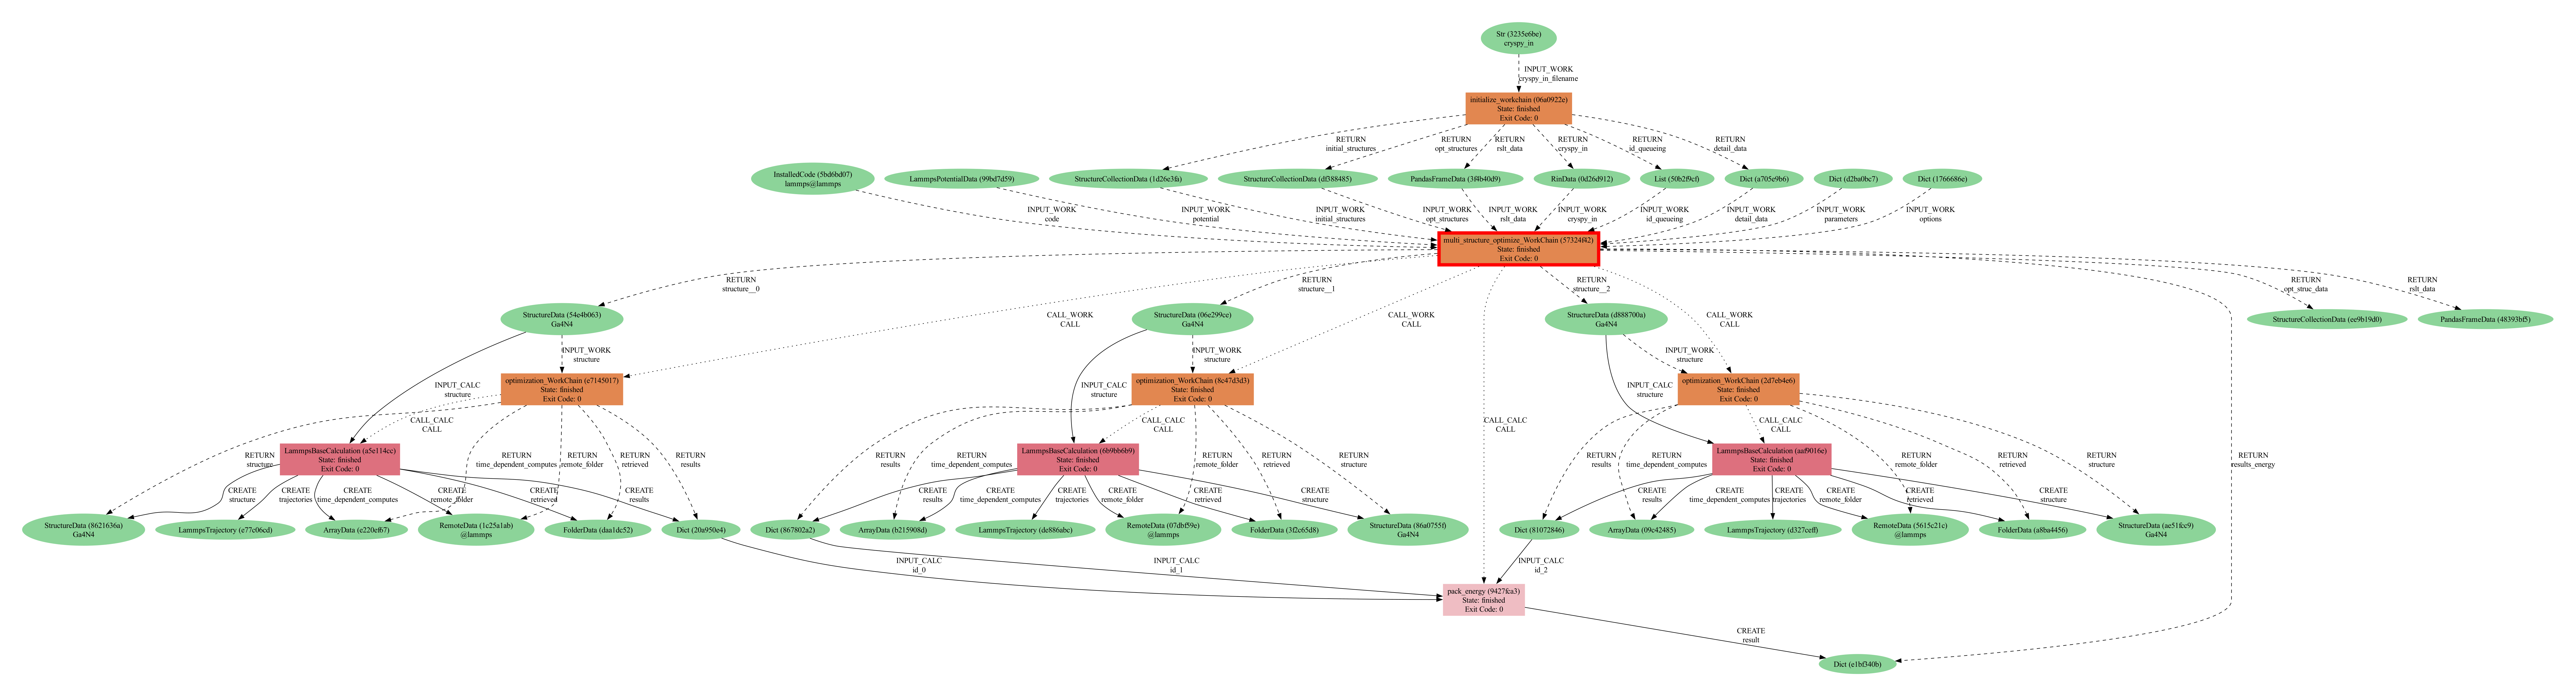

In [20]:
import subprocess
import fitz  # PyMuPDF
from PIL import Image
import io
from IPython.display import display

pk = node.pk

# Step 1: verdi コマンドで .dot.pdf を生成
subprocess.call(f"verdi node graph generate {pk}", shell=True)

# Step 2: PyMuPDF で PDF を開いて画像化
pdf_path = f"{pk}.dot.pdf"
doc = fitz.open(pdf_path)
page = doc[0]
pix = page.get_pixmap(dpi=150)

# Step 3: PIL で画像として表示
image = Image.open(io.BytesIO(pix.tobytes()))
display(image)

In [21]:
result

{'structure': {'0': <StructureData: uuid: 54e4b063-b083-4c35-9740-3ab94fac1648 (pk: 10717)>,
  '1': <StructureData: uuid: 06e299ce-ef41-469d-9218-823a6d25f5ea (pk: 10719)>,
  '2': <StructureData: uuid: d888700a-0b58-472c-83f6-8673e9e235bf (pk: 10721)>},
 'results_energy': <Dict: uuid: e1bf340b-df8b-49e2-97de-788afe24af67 (pk: 10745)>,
 'opt_struc_data': <StructureCollectionData: uuid: ee9b19d0-7909-4472-bbd9-e515b03190fb (pk: 10746)>,
 'rslt_data': <PandasFrameData: uuid: 48393bf5-1775-4352-908a-6560f97ef455 (pk: 10747)>}

In [22]:
result_energy = result['results_energy'].get_dict()
result_energy

{'index': ['id_1', 'id_0', 'id_2'],
 'energy': [-18.577310631527, 10.798535769267, 83.419536552058]}

In [ ]:
# result["results"]["0"].get_dict()

In [ ]:
# retrieved = result['retrieved']['0']  # IDが0の場合

# # ファイル名一覧を取得
# retrieved.list_object_names()  # これでファイル名のリストが得られる


In [ ]:
# result['results']['2']['final_etotal']  # 結果のエネルギーを取得

In [ ]:
# from pymatgen.io.ase import AseAtomsAdaptor

# # AiiDAのStructureDataノードを取得
# structure_node = result['structure']['0']

# # pymatgen Structure に変換
# pymatgen_structure = structure_node.get_pymatgen_structure()

# # 画面に表示（整形出力）
# print(pymatgen_structure)
